# **COUPLED CLIMATE EPIDEMIOLOGICAL MODEL**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.stats import spearmanr

In [2]:
# Climate Parameters with Stabilized Ranges
def Temp(t, offset=0):
    return np.clip(25 + offset + 5*np.cos(2*np.pi*t/365), 18, 38)

def Rain(t, offset=0):
    return np.clip(50 + offset + 25*np.sin(2*np.pi*t/365 - np.pi/2), 10, 150)

def Humid(t, offset=0):
    return np.clip(70 + offset + 10*np.sin(2*np.pi*t/365), 50, 90)

In [3]:
# Stabilized Disease Model Parameters
params = {
    'beta_d': 0.25,  # Base dengue transmission
    'beta_m': 0.18,  # Base malaria transmission
    'theta': 0.08,   # Dengue enhancement factor
    'delta': 0.05,   # Malaria enhancement factor
    'outbreak_threshold': 50,  # Cases/day for intervention
    'max_intervention': 0.6,    # Max transmission reduction
    'vector_scale': 0.001,     # Vector-human ratio
    'vector_seasonality': 0.3  # Seasonal variation
}

In [4]:
def model(y, t, T_func, R_func):
    S, I_d, I_m = y
    T = T_func(t)
    R = R_func(t)
    H = Humid(t)

    # Climate-modulated vector population
    V_d = 2000 * (1 + params['vector_seasonality']*np.sin(2*np.pi*t/180))
    V_m = 1500 * (1 + 0.2*np.sin(2*np.pi*t/365))

    # Climate-adjusted transmission rates with increased sensitivity
    climate_factor_d = 1 + 0.1*(T-28) + 0.02*R  # Increased sensitivity to temperature and rainfall
    climate_factor_m = 1 + 0.08*(T-24) + 0.025*H  # Increased sensitivity to temperature and humidity

    # Coupled transmission equations
    λ_d = params['beta_d'] * climate_factor_d * V_d/100000 * (1 + params['theta']*I_m)
    λ_m = params['beta_m'] * climate_factor_m * V_m/100000 * (1 + params['delta']*I_d)

    # Adaptive intervention
    intervention = 1 - params['max_intervention']*(I_d + I_m)/params['outbreak_threshold']
    intervention = np.clip(intervention, 1-params['max_intervention'], 1.0)

    dS = -(λ_d + λ_m)*S * intervention
    dId = λ_d*S - 0.14*I_d  # 1/7 recovery rate
    dIm = λ_m*S - 0.1*I_m   # 1/10 recovery rate

    return [dS, dId, dIm]

In [5]:
# Simulation Parameters
N = 100000  # Total population
y0 = [N-100, 50, 30]  # Initial infections
t = np.linspace(0, 1095, 1096)  # Extended to 3 years


In [6]:
# Function to calculate risk for given climate offsets
def calculate_risk(temp_offset, rain_offset):
    def mod_T(t): return Temp(t, offset=temp_offset)
    def mod_R(t): return Rain(t, offset=rain_offset)

    try:
        # Run simulation
        s = odeint(lambda y, t: model(y, t, mod_T, mod_R), y0, t, mxstep=5000)
        if np.isnan(s).any():
            return 0
        # Calculate risk as the maximum outbreak severity
        return np.max([s[:, 1].max(), s[:, 2].max()]) / 1000
    except:
        return 0

In [7]:
# Generate data for line plots
temp_offsets = np.linspace(-3, 3, 20)
rain_offsets = np.linspace(-30, 30, 20)

temp_risks = [calculate_risk(dT, 0) for dT in temp_offsets]  # Rainfall at baseline
rain_risks = [calculate_risk(0, dR) for dR in rain_offsets]   # Temperature at baseline

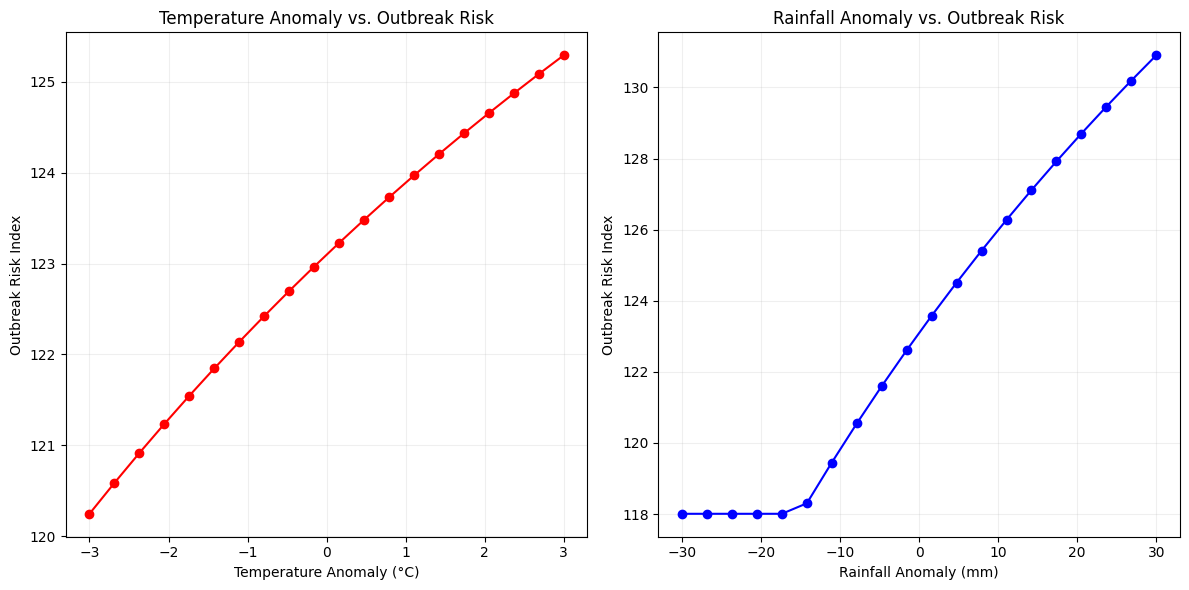

In [8]:
# Plot the results
plt.figure(figsize=(12, 6))

# Temperature vs. Risk
plt.subplot(1, 2, 1)
plt.plot(temp_offsets, temp_risks, 'r-', marker='o')
plt.title('Temperature Anomaly vs. Outbreak Risk')
plt.xlabel('Temperature Anomaly (°C)')
plt.ylabel('Outbreak Risk Index')
plt.grid(alpha=0.2)

# Rainfall vs. Risk
plt.subplot(1, 2, 2)
plt.plot(rain_offsets, rain_risks, 'b-', marker='o')
plt.title('Rainfall Anomaly vs. Outbreak Risk')
plt.xlabel('Rainfall Anomaly (mm)')
plt.ylabel('Outbreak Risk Index')
plt.grid(alpha=0.2)

plt.tight_layout()
plt.show()

In [9]:
# Realistic Coupled Outbreak Dynamics
def realistic_model(y, t):
    S, I_d, I_m = y
    T, R, H = Temp(t), Rain(t), Humid(t)

    # Climate-modulated vector population
    V_d = 2000 * (1 + params['vector_seasonality']*np.sin(2*np.pi*t/180))
    V_m = 1500 * (1 + 0.2*np.sin(2*np.pi*t/365))

    # Climate-adjusted transmission rates
    climate_factor_d = 1 + 0.02*(T-28) + 0.005*R
    climate_factor_m = 1 + 0.015*(T-24) + 0.008*H

    # Coupled transmission equations
    λ_d = params['beta_d'] * climate_factor_d * V_d/N * (1 + params['theta']*I_m)
    λ_m = params['beta_m'] * climate_factor_m * V_m/N * (1 + params['delta']*I_d)

    # Adaptive intervention
    intervention = 1 - params['max_intervention']*(I_d + I_m)/params['outbreak_threshold']
    intervention = np.clip(intervention, 1-params['max_intervention'], 1.0)

    dS = -(λ_d + λ_m)*S * intervention
    dId = λ_d*S - 0.14*I_d  # 1/7 recovery rate
    dIm = λ_m*S - 0.1*I_m   # 1/10 recovery rate

    return [dS, dId, dIm]

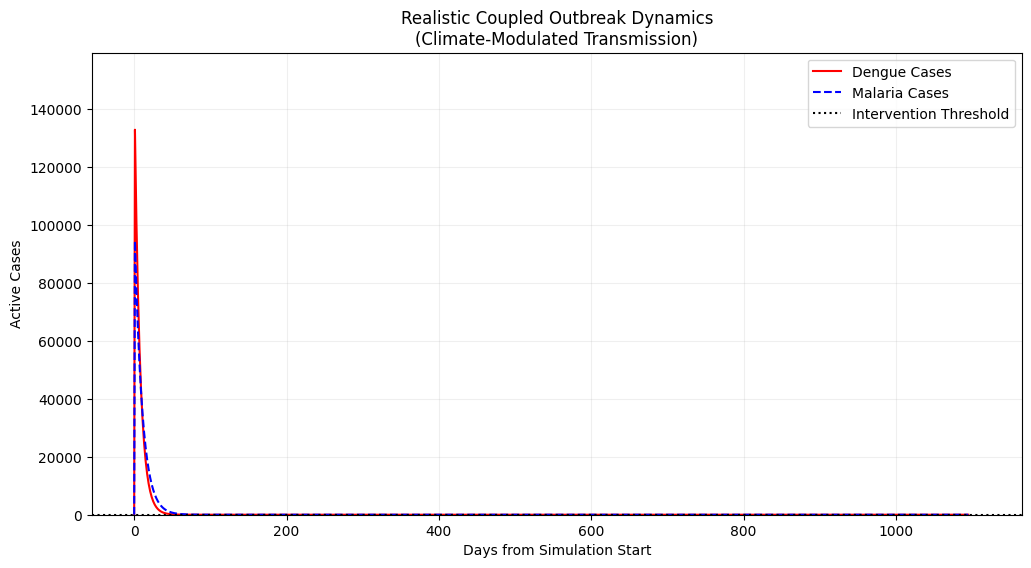

In [12]:
# Simulation Parameters for Realistic Dynamics
sol = odeint(realistic_model, y0, t, mxstep=5000)

# Plot Realistic Coupled Outbreak Dynamics
plt.figure(figsize=(12, 6))
plt.plot(t, sol[:, 1], 'r-', label='Dengue Cases')
plt.plot(t, sol[:, 2], 'b--', label='Malaria Cases')
plt.axhline(params['outbreak_threshold'], color='k', linestyle=':', label='Intervention Threshold')

# Climate bands
for month in range(0, 1095, 30):
    T = Temp(month)
    alpha = 0.1*(T > 30) + 0.05*(T < 20)
    plt.axvspan(month, month+30, color='gray', alpha=alpha)

plt.title('Realistic Coupled Outbreak Dynamics\n(Climate-Modulated Transmission)')
plt.xlabel('Days from Simulation Start')
plt.ylabel('Active Cases')
plt.legend()
plt.ylim(0, 1.2*np.max(sol[:, 1:3]))
plt.grid(alpha=0.2)
plt.show()

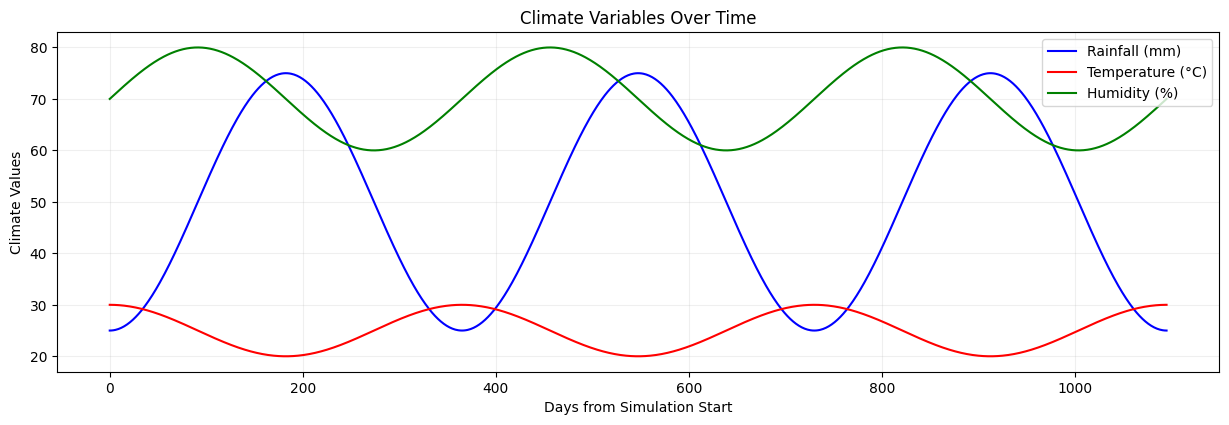

In [13]:
# Phase-Plane Plots and Climate Variables
plt.figure(figsize=(15, 15))

# Climate Variables Over Time
plt.subplot(3, 1, 1)
plt.plot(t, [Rain(ti) for ti in t], 'b-', label='Rainfall (mm)')
plt.plot(t, [Temp(ti) for ti in t], 'r-', label='Temperature (°C)')
plt.plot(t, [Humid(ti) for ti in t], 'g-', label='Humidity (%)')
plt.title('Climate Variables Over Time')
plt.xlabel('Days from Simulation Start')
plt.ylabel('Climate Values')
plt.legend()
plt.grid(alpha=0.2)

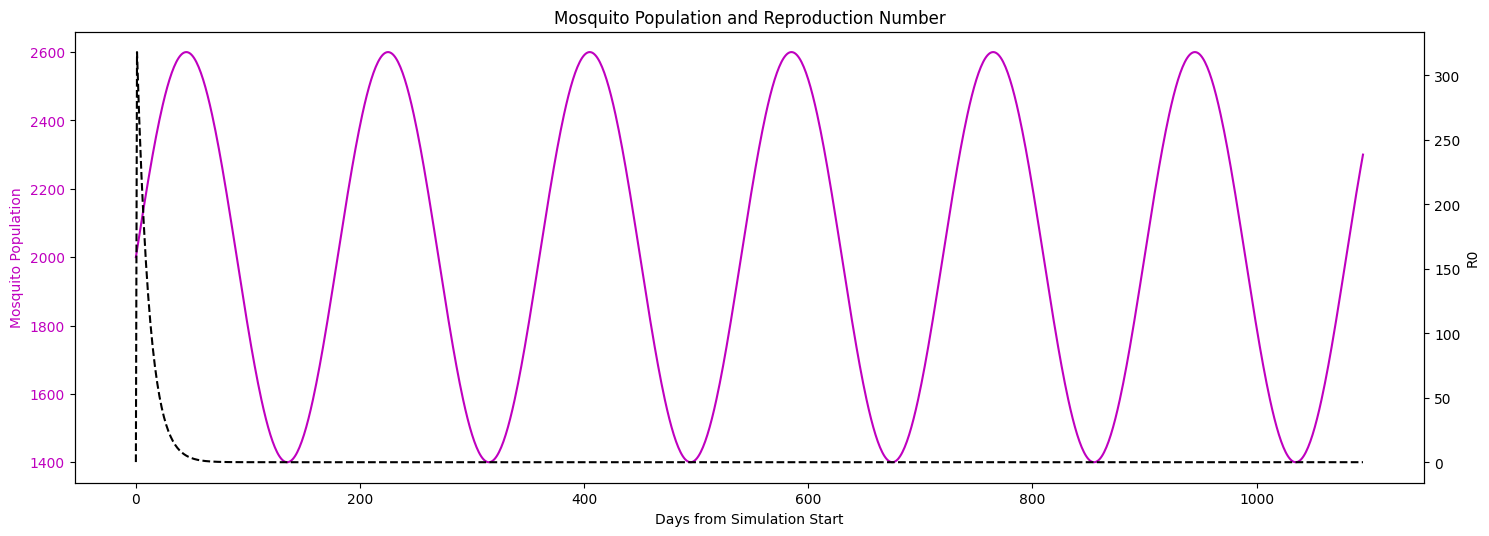

In [17]:
plt.figure(figsize=(15, 15))
# Mosquito Population and Reproduction Number
plt.subplot(3, 1, 2)
def calculate_mosquito_population(t):
    return 2000 * (1 + params['vector_seasonality']*np.sin(2*np.pi*t/180))

def calculate_reproduction_number(t, S, I_d, I_m):
    T, R, H = Temp(t), Rain(t), Humid(t)
    V_d = calculate_mosquito_population(t)
    climate_factor_d = 1 + 0.02*(T-28) + 0.005*R
    λ_d = params['beta_d'] * climate_factor_d * V_d/N * (1 + params['theta']*I_m)
    R0_d = λ_d / 0.14  # Basic reproduction number for dengue
    return R0_d

mosquito_population = [calculate_mosquito_population(ti) for ti in t]
R0 = [calculate_reproduction_number(ti, sol[i, 0], sol[i, 1], sol[i, 2]) for i, ti in enumerate(t)]

ax1 = plt.gca()
ax2 = ax1.twinx()

ax1.plot(t, mosquito_population, 'm-', label='Mosquito Population')
ax1.set_xlabel('Days from Simulation Start')
ax1.set_ylabel('Mosquito Population', color='m')
ax1.tick_params(axis='y', labelcolor='m')

ax2.plot(t, R0, 'k--', label='R0 (Dengue)')
ax2.set_ylabel('R0', color='k')
ax2.tick_params(axis='y', labelcolor='k')

plt.title('Mosquito Population and Reproduction Number')
plt.tight_layout()
plt.show()

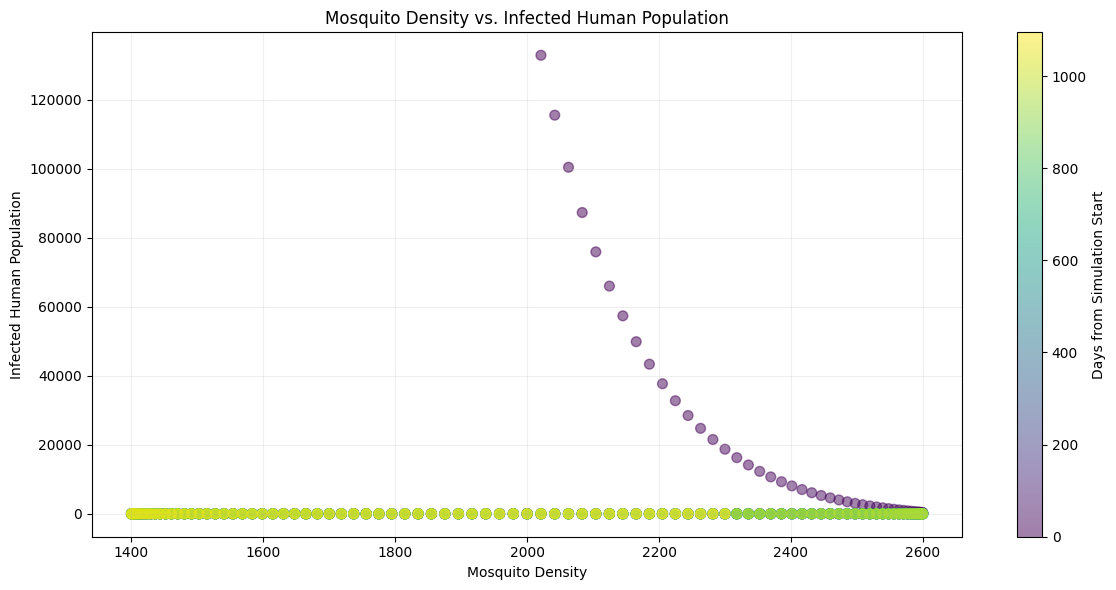

In [18]:
# Mosquito Density vs. Infected Human Population
plt.figure(figsize=(12, 6))
V_d = 2000 * (1 + params['vector_seasonality']*np.sin(2*np.pi*t/180))
scatter = plt.scatter(V_d, sol[:, 1], c=t, cmap='viridis', alpha=0.5, s=50)  # Increased size with s=50
plt.colorbar(scatter, label='Days from Simulation Start')
plt.title('Mosquito Density vs. Infected Human Population')
plt.xlabel('Mosquito Density')
plt.ylabel('Infected Human Population')
plt.grid(alpha=0.2)
plt.tight_layout()
plt.show()

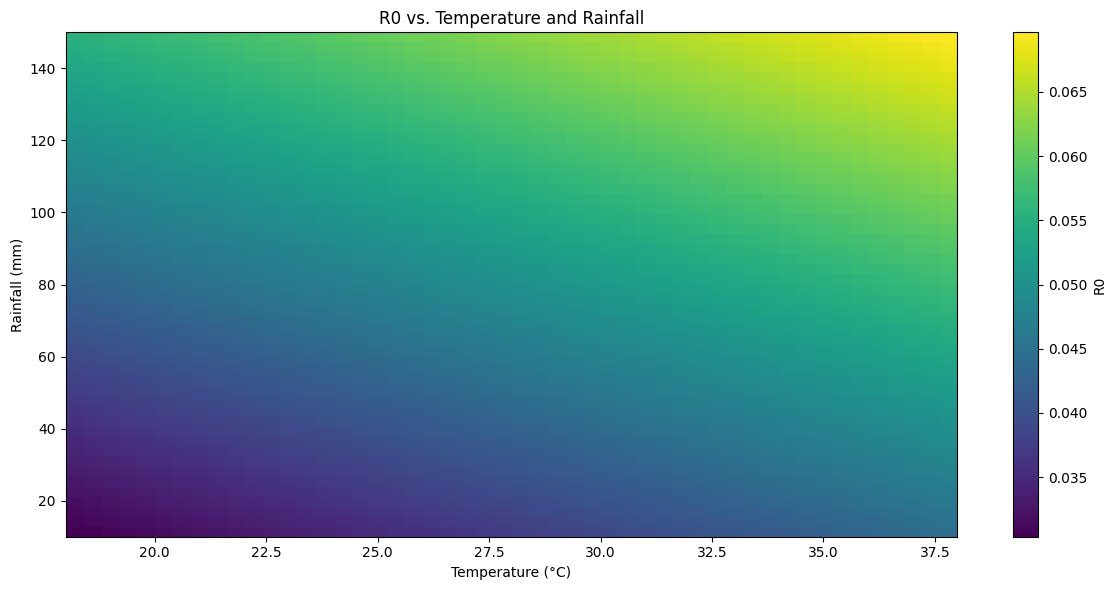

In [19]:
# Heatmap: R0 vs. Temperature and Rainfall
temp_values = np.linspace(18, 38, 50)
rain_values = np.linspace(10, 150, 50)
R0_matrix = np.zeros((50, 50))

for i, temp in enumerate(temp_values):
    for j, rain in enumerate(rain_values):
        def mod_T(t): return temp
        def mod_R(t): return rain
        s = odeint(lambda y, t: model(y, t, mod_T, mod_R), y0, t[:365], mxstep=5000)
        if np.isnan(s).any():
            R0_matrix[j, i] = 0
        else:
            T = temp
            R = rain
            V_d = 2000 * (1 + params['vector_seasonality']*np.sin(2*np.pi*0/180))
            climate_factor_d = 1 + 0.02*(T-28) + 0.005*R
            λ_d = params['beta_d'] * climate_factor_d * V_d/N
            R0 = λ_d / 0.14
            R0_matrix[j, i] = R0

plt.figure(figsize=(12, 6))
plt.imshow(R0_matrix, extent=[18, 38, 10, 150], aspect='auto', cmap='viridis', origin='lower')
plt.colorbar(label='R0')
plt.title('R0 vs. Temperature and Rainfall')
plt.xlabel('Temperature (°C)')
plt.ylabel('Rainfall (mm)')
plt.tight_layout()
plt.show()

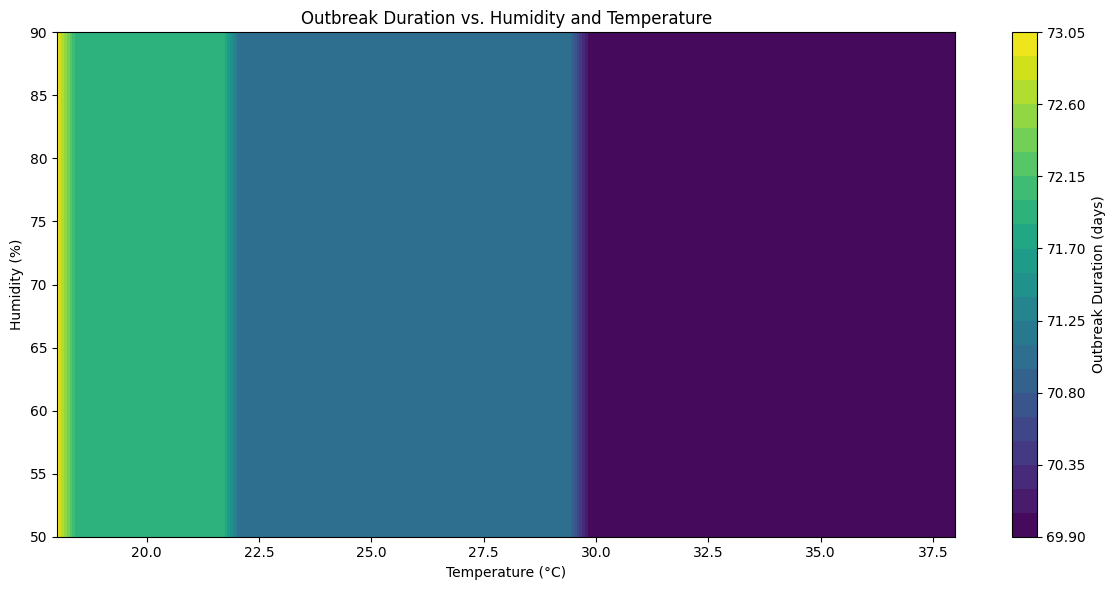

In [20]:
# Contour Plot: Outbreak Duration vs. Humidity and Temperature
temp_values = np.linspace(18, 38, 50)
humid_values = np.linspace(50, 90, 50)
duration_matrix = np.zeros((50, 50))

for i, temp in enumerate(temp_values):
    for j, humid in enumerate(humid_values):
        def mod_T(t): return temp
        def mod_H(t): return humid
        s = odeint(lambda y, t: model(y, t, mod_T, Rain), y0, t, mxstep=5000)
        if np.isnan(s).any():
            duration_matrix[j, i] = 0
        else:
            # Calculate outbreak duration as the number of days with infected population above a threshold
            outbreak = s[:, 1] + s[:, 2] > 100
            duration = np.sum(outbreak)
            duration_matrix[j, i] = duration

plt.figure(figsize=(12, 6))
contour = plt.contourf(temp_values, humid_values, duration_matrix, levels=20, cmap='viridis')
plt.colorbar(contour, label='Outbreak Duration (days)')
plt.title('Outbreak Duration vs. Humidity and Temperature')
plt.xlabel('Temperature (°C)')
plt.ylabel('Humidity (%)')
plt.tight_layout()
plt.show()

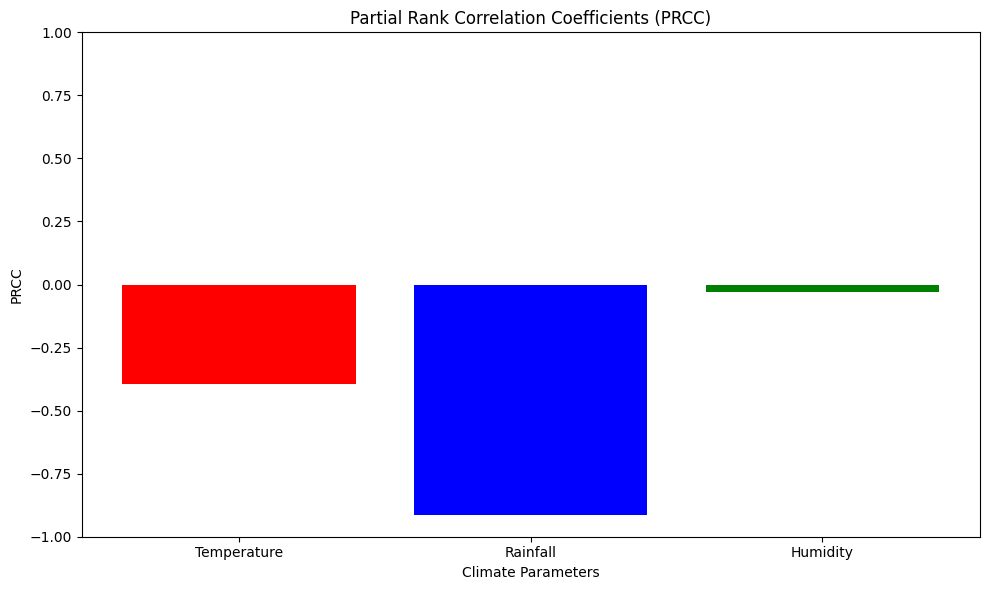

In [22]:
# PRCC Analysis
np.random.seed(42)
num_samples = 1000
temp_perts = np.random.uniform(-3, 3, num_samples)
rain_perts = np.random.uniform(-30, 30, num_samples)
humid_perts = np.random.uniform(-20, 20, num_samples)

# Function to calculate total infections
def calculate_total_infections(temp_offset=0, rain_offset=0, humid_offset=0):
    def mod_T(t): return Temp(t, offset=temp_offset)
    def mod_R(t): return Rain(t, offset=rain_offset)
    def mod_H(t): return Humid(t, offset=humid_offset)

    try:
        # Run simulation
        s = odeint(lambda y, t: model(y, t, mod_T, mod_R), y0, t, mxstep=5000)
        if np.isnan(s).any():
            return 0
        # Calculate total infections as the sum of infected individuals over time
        total_infections = np.sum(s[:, 1] + s[:, 2])
        return total_infections
    except:
        return 0

total_infections = np.zeros(num_samples)
for i in range(num_samples):
    total_infections[i] = calculate_total_infections(temp_perts[i], rain_perts[i], humid_perts[i])

# Calculate PRCC
prcc_temp = spearmanr(temp_perts, total_infections)[0]
prcc_rain = spearmanr(rain_perts, total_infections)[0]
prcc_humid = spearmanr(humid_perts, total_infections)[0]

# Plot PRCC
plt.figure(figsize=(10, 6))
plt.bar(['Temperature', 'Rainfall', 'Humidity'], [prcc_temp, prcc_rain, prcc_humid], color=['r', 'b', 'g'])
plt.xlabel('Climate Parameters')
plt.ylabel('PRCC')
plt.title('Partial Rank Correlation Coefficients (PRCC)')
plt.ylim(-1, 1)
plt.tight_layout()
plt.show()